In [1]:
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

Goals:
- validate the assumption that if maximizer of expected log likelihood yields perfect classification, maximizer of expected pen log Lh has small noise condition
- Compute loss distribution by Monte Carlo compare with quantiles
- effect of nuisance parameter

In [2]:
import numpy as np
from scipy.special import softmax


In [3]:
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

sig = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9],
                [10, 11, 12]])

inter = np.einsum('ij, jk-> ikj', X, X.T, order='K').reshape((3, 3 * 3), order='F')



print(inter)
print(np.kron(sig, np.ones((1, 3)))[0] * inter)
(np.kron(sig, np.ones((1, 3)))[0] * inter).reshape((3, 3, 3), order='A')[:,:,0]


[[ 1  4  7  4 10 16  9 18 27]
 [ 4 16 28 10 25 40 18 36 54]
 [ 7 28 49 16 40 64 27 54 81]]
[[  1.   4.   7.   8.  20.  32.  27.  54.  81.]
 [  4.  16.  28.  20.  50.  80.  54. 108. 162.]
 [  7.  28.  49.  32.  80. 128.  81. 162. 243.]]


array([[ 1.,  4.,  7.],
       [ 4., 16., 28.],
       [ 7., 28., 49.]])

$\frac{\delta}{\delta W_{kj}} = - \lambda \sum_{i=1}^n(\mathbb{X}_{ki} - \sigma(\sum_{j=1}^dW_{kj}X_{ji}))\sigma'(W_kX_i))X_{ji}$

Need to assume entries of eta not 0 or 1 else there is no MLE/ cannot converge since entries of W go towards +/- infinity

In [4]:
class Experiment():
    def __init__(self, n, lamb, lambda_W, lambda_X, d, K, max_it, eps_W, eps_X, gamma):
        self.max_it = max_it
        self.eps_W = eps_W
        self.eps_X = eps_X
        self.gamma = gamma
        self.n = n
        self.lamb = lamb
        self.lambda_X = lambda_X
        self.lambda_W = lambda_W
        self.d = d
        self.K = K
        self.W = np.random.randn(K, d)
        self.X_n = sample_features(self.W, self.n, self.K)
        self.Y = sample_Y(self.W, self.X_n)
        self.exp_Y = softmax(sigma(self.W @ self.X_n), axis=0)
        self.W_tilde = np.zeros((K, d))
        self.W_star = np.zeros((K, d))
        self.X_tilde = np.zeros_like(self.Y)
        self.X_star = np.zeros_like(self.Y)
        self.final_bias = np.inf
        self.struct_pens = []
        self.pen_logLHs = []
        self.diff_Ws = []
        self.diff_Xs = []
        self.losses = []
        self.biases = []
        self.final_loss = np.inf
        self.iterations = 0
    
    def optimize_exp_log_lh(self):
        W_star, X_star, _, _, _, _, _, _, _ = grad_asc(self.exp_Y, self.Y, self.X_n, self.lamb, self.lambda_W, self.lambda_X, self.max_it, self.eps_W, self.eps_X, self.gamma, W_star=None, W=self.W, exp=True)
        self.W_star = W_star
        self.X_star = X_star
        
    def optimize_log_lh(self):
        W_tilde, X_tilde, struct_pens, pen_logLHs, diff_Ws, diff_Xs, i, losses, biases = grad_asc(self.Y, self.Y, self.X_n, self.lamb, self.lambda_W, self.lambda_X, self.max_it, self.eps_W, self.eps_X, self.gamma, W_star=self.W_star, W=self.W, exp=False)
        self.W_tilde = W_tilde
        self.X_tilde = X_tilde
        self.struct_pens = struct_pens
        self.pen_logLHs = pen_logLHs
        self.diff_Ws = diff_Ws
        self.diff_Xs = diff_Xs
        self.iterations = i
        self.losses = losses
        self.biases = biases
        self.final_loss = losses[-1]
        self.final_bias = biases[-1]

In [5]:
class MonteCarlo():
    def __init__(self, trials, n, lamb, lambda_W, lambda_X, d, K, max_it, eps_W, eps_X, gamma):
        self.trials = trials
        self.max_it = max_it
        self.eps_W = eps_W
        self.eps_X = eps_X
        self.gamma = gamma
        self.n = n
        self.lamb = lamb
        self.lambda_X = lambda_X
        self.lambda_W = lambda_W
        self.d = d
        self.K = K
        self.W = np.random.randn(K, d)
        self.X_n = sample_features(self.W, self.n, self.K)
        self.exp_Y = softmax(sigma(self.W @ self.X_n), axis=0)
        self.final_bias = np.inf
        self.struct_pens = []
        self.pen_logLHs = []
        self.losses = []
        self. D = metr_tens(self.W, self.X_n, self.lamb, self.lambda_W)
        self.Sigma = var_Y(self.W, self.X_n)
        self.Var_ups = block_diag(np.zeros((K * d, K * d)), self.Sigma)
        self.F_inv = inv_Fisher(self.W, self.X_n, self.lamb, self.lambda_W, self.lambda_X)
        self.eff_rad = eff_rad(self.D, self.Var_ups, self.F_inv, self.n)
        # self.eff_dim
        
    def optimize_exp_log_lh(self):
        W_star, X_star, _, _, _, _, _, _, _ = grad_asc(self.exp_Y, self.X_n, self.lamb, self.lambda_W, self.lambda_X, self.max_it, self.eps_W, self.eps_X, self.gamma, W_star=None, W=self.W)
        self.W_star = W_star
        self.X_star = X_star
        
    def optimize_log_lh(self, Y):
        W_tilde, X_tilde, struct_pens, pen_logLHs, diff_Ws, diff_Xs, i, losses, biases = grad_asc(Y, self.X_n, self.lamb, self.lambda_W, self.lambda_X, self.max_it, self.eps_W, self.eps_X, self.gamma, W_star=self.W_star, W=self.W)
        return losses[-1]
        
    def run_trial(self):
        Y = sample_Y(self.W, self.X_n)
        self.optimize_log_lh(Y)
        
    def simulate(self):
        num_workers = min(multiprocessing.cpu_count(), self.trials)  # Get available cores
        self.losses = Parallel(n_jobs=num_workers)(
            delayed(self.optimize_log_lh)(sample_Y(self.W, self.X_n)) for _ in tqdm(range(self.trials))
        )
    
    # def simulate(self):
    #     for _ in tqdm(range(self.trials)):
    #         Y = sample_Y(self.W, self.X_n)
    #         self.optimize_log_lh(Y)


In [14]:
trials = 10000
d = 30
K = 10
n = 100
lamb = 1
lambda_W = 1
lambda_X = 1
max_it = 10000
eps_W = 1e-5
eps_X = 1e-5
gamma = 0.001
mc = MonteCarlo(trials, n, lamb, lambda_W, lambda_X, d, K, max_it, eps_W, eps_X, gamma)

D:(1300, 1300)
F_inv:(1300, 1300)
Var_ups:(1300, 1300)


In [15]:
mc.optimize_exp_log_lh()

In [ ]:
mc.simulate()

  8%|▊         | 752/10000 [12:43<2:25:41,  1.06it/s]

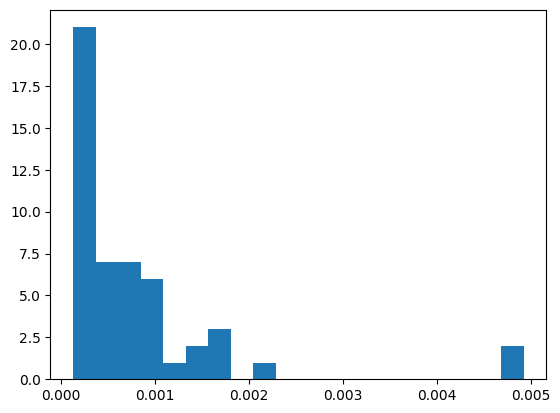

In [ ]:
plt.hist(mc.losses)
plt.show()